In [1]:
from demodulation import *
#
import decoding as decode
import scipy
import numpy as np
import sounddevice as sd
from scipy.io.wavfile import write, read
from scipy.signal import correlate
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fftshift
from sklearn.preprocessing import minmax_scale
import os
import math

In [2]:
SYNC_FREQ = [[348, 894], [5298, 5792]]

### Record or read

8841248


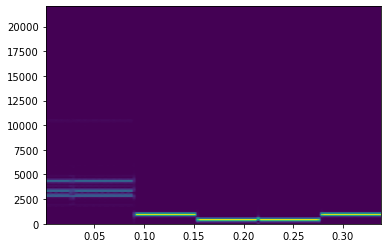

In [8]:
filename = os.path.join('D:\GitHub\EL5207_project\mod_2img_sync.wav')
# listen
# record(2, SAMPLE_FREQ, filename) 
# read
fs, audio = read(filename)
print(len(audio)) 
wave0 = filter_freq(audio, SYNC_FREQ[0][0], 100, SAMPLE_FREQ)
wave1 = filter_freq(audio, SYNC_FREQ[0][1], 100, SAMPLE_FREQ)
wave_sum = wave0 + wave1
spectrum, freqs, t, im = plt.specgram(audio[-15000:], Fs = SAMPLE_FREQ, scale = 'linear')
plt.show()

In [9]:
# build the start and end signal
def bfsk_modulate(bit_array, space_freq, mark_freq, baud, sample_rate):
    seconds_per_bit = 1 / baud
    samples_per_bit = int(sample_rate * seconds_per_bit)
    t = np.linspace(0, seconds_per_bit, samples_per_bit)
    space = np.sin(space_freq * 2 * np.pi * t)
    mark = np.sin(mark_freq * 2 * np.pi * t)
    signal = np.array([])
    for bit in bit_array:
        if bit == 0:
            signal = np.append(signal, space)
        elif bit == 1:
            signal = np.append(signal, mark)
    return signal

ref = bfsk_modulate([1,1,0,0], 348, 894, 16, 44100)

In [15]:
def sync_detect(audio, sync_freq):
    # Filter in the frequency
    wave0 = filter_freq(audio, sync_freq[0], 100, SAMPLE_FREQ)
    wave1 = filter_freq(audio, sync_freq[1], 100, SAMPLE_FREQ)
    wave_sum = wave0 + wave1
    # get the reference
    ref_init = bfsk_modulate([1, 1, 1, 1], sync_freq[0], sync_freq[1], BAUD, SAMPLE_FREQ)
    ref_end = bfsk_modulate([0, 0, 0, 0], sync_freq[0], sync_freq[1], BAUD, SAMPLE_FREQ)
    # From this we get the peaks
    start = 0
    end = 0
    #
    corr_init = []
    corr_end = []
    for i in range(math.floor((len(wave_sum))/len(ref_init))):
        y_w = wave_sum[i* len(ref_init):(i+1) * len(ref_init)]
        cor = correlate(ref_init, y_w, mode='full', method='fft')
        corr_init.append(sum(cor**2))
        y_x = wave_sum[i* len(ref_end):(i+1) * len(ref_end)]
        cor = correlate(ref_end, y_x, mode='full', method='fft')
        corr_end.append(sum(cor**2)) 
    # return audio[start:end]
    print(corr_init[0], corr_init[-1])
    print(corr_end[0], corr_end[-1])
    print(np.where( corr_init == np.max(corr_init)))
    print(np.where( corr_end == np.max(corr_end)))
    start = np.where( corr_init == np.max(corr_init))[0][0]
    end = np.where( corr_end == np.max(corr_end))[0][0]
    print(start, end)
    # Get the location in sample points
    samples_per_bit = int(SAMPLE_FREQ / BAUD)
    start = int((start + 1)*samples_per_bit*4)
    end = int((end)*samples_per_bit*4)
    print(start, end)
    print(len(audio) - start)
    plt.plot(corr_init)
    plt.show()
    return audio[start:end]

1.295815446212349e+19 1.991793684244847e+19
1.033849594513997e+19 2.2072033236027863e+19
(array([801], dtype=int64),)
(array([801], dtype=int64),)
801 801
8841248 8830224
0


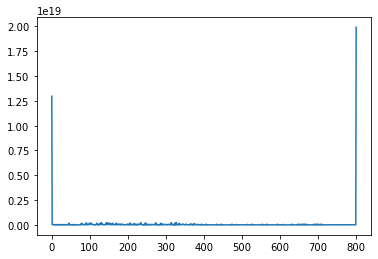

In [17]:
SYNC_FREQ = [[348, 894], [5298, 5792]] 
wave = sync_detect(audio, SYNC_FREQ[0])

In [111]:
corr=[]
for i in range(math.floor((len(wave_sum))/len(ref))):
    y_w = wave_sum[i* len(ref):(i+1) * len(ref)]
    cor = correlate(ref, y_w, mode='full', method='fft')
    corr.append(sum(cor**2))

In [112]:
start = np.where( corr == np.max(corr))[0]
start

array([0], dtype=int64)

In [113]:
samples_per_bit = int(SAMPLE_FREQ / BAUD)
start = (start + 1)*samples_per_bit*4

In [114]:
start

array([11024], dtype=int64)

In [98]:
corr[::-1]

[2.4979871629307224e+19,
 1.1084839248332292e+16,
 1.4570335807117948e+16,
 1.02709111586611e+16,
 1.4570335807117706e+16,
 1.0270911158661156e+16,
 1.4570335807117572e+16,
 1.0270911158661192e+16,
 1.4740286501545196e+16,
 9800049366816146.0,
 6618235420610902.0,
 3.5700387191902404e+16,
 6466977658027698.0,
 1.294299607428675e+16,
 7496135995505693.0,
 2.2840044483470548e+16,
 1.1073222792181728e+16,
 1.0596384236180848e+16,
 3478676608020330.0,
 1.5480749703188034e+16,
 1.0171223212208506e+16,
 3054231664645115.0,
 5062207494669872.0,
 1.3560048167528618e+16,
 6224230988551334.0,
 3.5024387619576124e+16,
 5073857852056835.0,
 5431878416478558.0,
 1.8840987401639064e+16,
 1.0270910094127824e+16,
 1.4647431811097152e+16,
 1.0946243434880476e+16,
 1.1135217538092842e+16,
 5140703803636921.0,
 8469040212197551.0,
 3160921830291521.0,
 7574399655106264.0,
 1.641392641797197e+16,
 1.4294639830635712e+16,
 5424173478881269.0,
 1902385477070862.8,
 8967709037223497.0,
 820453506561488.5,
 8

In [95]:
len(corr)

394

In [94]:
np.where( corr[::-1] == np.max(corr))

(array([393], dtype=int64),)

In [4]:
freqs = FREQUENCIES[0]
wave = sync_detect(audio, SYNC_FREQ[0])
wave = audio
print(len(wave))
# Text
# text_wave0 = filter_freq(audio, freqs[0][0], 20, fs)
# text_wave1 = filter_freq(audio, freqs[0][1], 20, fs)
# wave_sum = text_wave0 + text_wave1
# text_bin = fsk_demodulate(wave_sum, freqs[0][0], freqs[0][1], BAUD, fs)
# decod = decode.Decoding(text_bin, mode='text')
# decod_ch = decod.decod_data
# print(decod_ch)
# Image
# Red channel
r_wave0 = filter_freq(wave, freqs[1][0], 20, fs)
r_wave1 = filter_freq(wave, freqs[1][1], 20, fs)
r_sum = r_wave0 + r_wave1
r_bin = fsk_demodulate(r_sum, freqs[1][0], freqs[1][1], BAUD, fs)
# print(r_bin)
# Green channel
g_wave0 = filter_freq(wave, freqs[2][0], 20, fs)
g_wave1 = filter_freq(wave, freqs[2][1], 20, fs)
g_sum = g_wave0 + g_wave1
g_bin = fsk_demodulate(g_sum, freqs[2][0], freqs[2][1], BAUD, fs)
# Blue channel
b_wave0 = filter_freq(wave, freqs[3][0], 20, fs)
b_wave1 = filter_freq(wave, freqs[3][1], 20, fs)
b_sum = b_wave0 + b_wave1
b_bin = fsk_demodulate(b_sum, freqs[3][0], freqs[3][1], BAUD, fs)
# Image Assembly c:
print(len(r_bin), len(g_bin), len(b_bin))
colorlist = [r_bin, g_bin, b_bin]
decod = decode.Decoding(colorlist, mode='image')
decod_ch = decod.decod_data
plt.imshow(decod_ch, cmap='gray')
plt.show()

1574
2756
001
0 111
011
111
2 111
4337944
1574 1574 1574


AssertionError: Error: data must be multiple of 8

In [ ]:

for i in range(len(FREQUENCIES)): # Both transmitters
    freqs = FREQUENCIES[i]
    wave = sync_detect(audio, SYNC_FREQ[i])
    wave = audio
    print(len(wave))
    # Text
    text_wave0 = filter_freq(audio, freqs[0][0], 20, fs)
    text_wave1 = filter_freq(audio, freqs[0][1], 20, fs)
    wave_sum = text_wave0 + text_wave1
    text_bin = fsk_demodulate(wave_sum, freqs[0][0], freqs[0][1], BAUD, fs)
    decod = decode.Decoding(text_bin, mode='text')
    decod_ch = decod.decod_data
    print(decod_ch)
    # Image
    # Red channel
    r_wave0 = filter_freq(wave, freqs[1][0], 20, fs)
    r_wave1 = filter_freq(wave, freqs[1][1], 20, fs)
    r_sum = r_wave0 + r_wave1
    r_bin = fsk_demodulate(r_sum, freqs[1][0], freqs[1][1], BAUD, fs)
    # print(r_bin)
    # Green channel
    g_wave0 = filter_freq(wave, freqs[2][0], 20, fs)
    g_wave1 = filter_freq(wave, freqs[2][1], 20, fs)
    g_sum = g_wave0 + g_wave1
    g_bin = fsk_demodulate(g_sum, freqs[2][0], freqs[2][1], BAUD, fs)
    # Blue channel
    b_wave0 = filter_freq(wave, freqs[3][0], 20, fs)
    b_wave1 = filter_freq(wave, freqs[3][1], 20, fs)
    b_sum = b_wave0 + b_wave1
    b_bin = fsk_demodulate(b_sum, freqs[3][0], freqs[3][1], BAUD, fs)
    # Image Assembly c:
    print(len(r_bin), len(g_bin), len(b_bin))
    colorlist = [r_bin, g_bin, b_bin]
    decod = decode.Decoding(colorlist, mode='image')
    decod_ch = decod.decod_data
    plt.imshow(decod_ch, cmap='gray')
    plt.show()

TypeError: unsupported operand type(s) for -: 'list' and 'int'